In [1]:
import numpy as np


## Generate a sequence of thicknesses representing shifts in the sedimentation history:

In [3]:
np.random.seed(37893)
min_thick = 0
n = 10
simulated_thickness = 20
while min_thick < 0.3:
    zs = np.random.uniform(0, simulated_thickness, size=n - 1)
    ordered_zs = np.sort(zs)
    ordered_zs = np.append(ordered_zs, simulated_thickness)
    ordered_zs = np.append(0, ordered_zs)
    thicknesses = np.diff(ordered_zs)
    min_thick = np.min(thicknesses)

In [4]:
print(f"The thickness array is:{thicknesses})")
print(f"The minimum thickness is:{min_thick}")
print(f"The total thickness is:{np.sum(thicknesses)}")
print(f"The mean thickness is:{np.mean(thicknesses)}")
print(f"The number of layers is:{len(thicknesses)}")

The thickness array is:[2.0682547  3.9534124  2.29212944 0.79664357 1.42553114 0.59364403
 1.21076477 4.53873408 0.68882167 2.4320642 ])
The minimum thickness is:0.5936440340197162
The total thickness is:20.0
The mean thickness is:2.0
THe number of layers is:10


### The domain (Grid and attributes)

In [12]:
# creating a grid according to the MODFLOW convention
xs = np.arange(0, 100.1, 0.5)
ys = np.arange(0, 80.1, 0.5)
zs = np.arange(0, 20.1, 0.4)
z, y, x = np.meshgrid(zs, ys, xs, indexing="ij")
z = np.flip(z, axis=0)
y = np.flip(y, axis=1)
facies = np.ones_like(x, dtype=np.int32) * (-1)
dip_array = np.zeros_like(x)
dip_dir_array = np.zeros_like(x)

## Create a complex algorithm that represent a certain environment:

In [17]:
from hyvr import channel, half_ellipsoid
from hyvr.tools import ferguson_curve
from hyvr.utils import min_distance

z0 = 0.0
P = np.column_stack([x[0, :, :].ravel(), y[0, :, :].ravel()])
for thick in thicknesses:
    # creating anastamosing channel pattern:
    main_channels = []
    channels = []
    for i in range(6):
        ystart = np.random.uniform(0, 600)
        channel_curve = ferguson_curve(
            h=0.3,
            k=np.pi / 200,
            eps_factor=(np.pi / 1.5) ** 2,
            flow_angle=0.0,
            s_max=1500,
            xstart=-500,
            ystart=ystart,
        )
        main_channels.append(channel_curve)
        indexes = np.random.choice(
            np.arange(channel_curve[0].shape[0]), size=4, replace=False
        )
        xstart = channel_curve[0][indexes]
        ystart = channel_curve[1][indexes]
        for xp, yp in zip(xstart, ystart):
            channel_derived_channel = ferguson_curve(
                h=0.3,
                k=np.pi / 200,
                eps_factor=(np.pi / 1.5) ** 2,
                flow_angle=np.random.uniform(-np.pi / 18, np.pi / 18),
                s_max=1000,
                xstart=xp,
                ystart=yp,
            )
            channels.append(channel_derived_channel)
    total_channels = main_channels + channels
    min_distance_array = np.zeros((P.shape[0], len(total_channels)))
    for i, channel_ in enumerate(total_channels):
        min_distance_array[:, i], _ = min_distance(channel_[0], channel_[1], P)
    # cut the proportion to 30 % of the cells in the x, y plane
    min_arr = min_distance_array.min(axis=1)
    # Assuming `min_array` and `t` are already defined
    # Get the sorted indices of t
    sorted_indices = np.argsort(min_arr)
    # Calculate the number of indices to select (30% of the total)
    num_indices = int(len(sorted_indices) * 0.3)
    # Select the last 30% of the indices
    selected_indices = sorted_indices[-num_indices:]

    primitive = np.ones_like(min_arr, dtype=np.int32) * 7
    primitive = np.ravel(primitive)
    primitive[selected_indices] = 6
    primitive = primitive.reshape(z.shape[1], z.shape[2])
    z_ = z[:, 0, 0]
    for i in range(z_.shape[0]):
        if z_[i] >= z0:
            facies[i, :, :] = primitive
    print(f"Finished the primitive of layer {z0 + thick}")
    ## Adding ponds:
    p_ponds = 0
    logic_tufa = (z >= z0) & (z <= z0 + thick)
    while p_ponds < 0.30:
        x_c = np.random.uniform(0, 900)
        y_c = np.random.uniform(0, 600)
        z_c = z0 + thick + np.random.uniform(0, 0.1)
        a = np.random.uniform(50, 80)
        b = np.random.uniform(30, 60)
        c = thick
        azim = np.random.uniform(20, -20)
        half_ellipsoid(
            facies,
            dip_array,
            dip_dir_array,
            x,
            y,
            z,
            center_coords=np.array([x_c, y_c, z_c]),
            dims=np.array([a, b, c]),
            azim=azim,
            facies=np.array([2]),
        )
        # k[facies_trough != -1] = np.random.lognormal(mu_tufa, sigma=sigma_tufa)
        p_ponds = np.sum(facies[logic_tufa] == 2) / np.sum(logic_tufa)
    print(f"Finished ponds in layer {z0 + thick}")
    ## Adding the channels, the ponds and the peat lenses
    for channel_ in main_channels:
        channel(
            facies,
            dip_array,
            dip_dir_array,
            x,
            y,
            z,
            z_top=z0 + thick,
            curve=np.c_[channel_[0], channel_[1]],
            parabola_pars=np.array([30, thick]),
            facies=np.array([4]),
        )
    for channel_ in channels:
        channel(
            facies,
            dip_array,
            dip_dir_array,
            x,
            y,
            z,
            z_top=z0 + thick,
            curve=np.c_[channel_[0], channel_[1]],
            parabola_pars=np.array([20, thick]),
            facies=np.array([4]),
        )
    print(f"Finished channels in layer {z0 + thick}")
    ## assiging peat to areas close to water bodies:
    water_bodies = (facies == 2) | (facies == 4)
    z_ = z[:, 0, 0]
    ind = np.where(z_ <= z0 + thick)
    layer = np.min(ind[0])
    layer
    water_bodies = water_bodies[layer, :, :]
    xs = x[layer, :, :][water_bodies]
    ys = x[layer, :, :][water_bodies]
    xs.shape
    ys.shape
    index_ = np.random.choice(np.arange(0, xs.shape[0]))
    ## Adding peat lenses:
    p_peat = 0
    if thick > 0.4:
        c = 0.4
    else:
        c = thick
    while p_peat < 0.20:
        index_ = np.random.choice(np.arange(0, xs.shape[0]))
        x_c = xs[index_]
        y_c = ys[index_]
        z_c = z0 + thick
        a = np.random.uniform(30, 60)
        b = np.random.uniform(20, 40)
        c = c
        azim = np.random.uniform(-20, 20)
        facies_code = np.random.choice([8, 9])
        half_ellipsoid(
            facies,
            dip_array,
            dip_dir_array,
            x,
            y,
            z,
            center_coords=np.array([x_c, y_c, z_c]),
            dims=np.array([a, b, c]),
            azim=azim,
            facies=np.array([facies_code]),
        )
        # k[facies_trough != -1] = np.random.lognormal(mu_tufa, sigma=sigma_tufa)
        logic_tufa = (z >= z0 + thick - c) & (z <= z0 + thick)
        p_peat = np.sum(facies[logic_tufa] == facies_code) / np.sum(logic_tufa)
    print(f"Finished the layer {z0 + thick}")
    # resetting z_0:
    z0 += thick

Finished the primitive of layer 2.0682546963182324
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside the ellipsoid
No points inside th

## Visualizing the Results

Text(0.5, 0, 'Z')

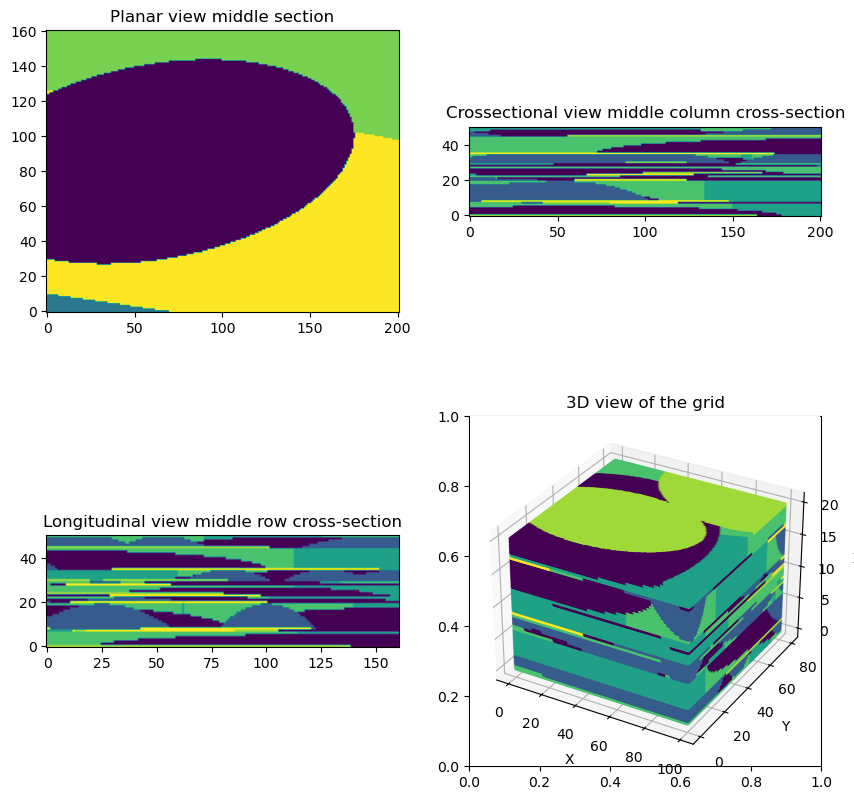

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(facies[int(facies.shape[0] / 2), :, :], origin="lower")
ax[0, 0].set_title("Planar view middle section")
ax[0, 1].imshow(facies[:, int(facies.shape[1] / 2), :], origin="lower")
ax[0, 1].set_title("Crossectional view middle column cross-section")
ax[1, 0].imshow(facies[:, :, int(facies.shape[2] / 2)], origin="lower")
ax[1, 0].set_title("Longitudinal view middle row cross-section")
# 3D view
ax3d = fig.add_subplot(224, projection="3d")
ax3d.scatter(
    x.ravel(), y.ravel(), z.ravel(), c=facies.ravel(), cmap="viridis", marker="."
)
ax3d.set_title("3D view of the grid")
ax3d.set_xlabel("X")
ax3d.set_ylabel("Y")
ax3d.set_zlabel("Z")